In [1]:
# Import packages
import os
import optuna
import pandas as pd
from graphviz import Digraph
from optuna.storages import JournalFileStorage, JournalStorage

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
num_nodes = 7
study_name = f"dcl_{num_nodes}"
optuna_dir = f"optuna/{study_name}"
storage = JournalStorage(JournalFileStorage(os.path.join(optuna_dir, "optuna.log")))
study = optuna.create_study(
    storage=storage,
    study_name=study_name,
    load_if_exists=True,
)

/tmp/ipykernel_3971809/2879116964.py:4: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = JournalStorage(JournalFileStorage(os.path.join(optuna_dir, "optuna.log")))
[I 2024-03-30 17:07:28,628] Using an existing study with name 'dcl_7' instead of creating a new one.


In [3]:
study_df = study.trials_dataframe()
# complete_df = study_df[study_df.state == "COMPLETE"]
complete_df = study_df
sorted_df = complete_df.sort_values(by="value", ascending=False)

In [4]:
sorted_df

,number,value,datetime_start,datetime_complete,duration,params_0_0_gate,params_0_0_loss,params_0_1_gate,params_0_1_loss,params_0_2_gate,...,params_6_3_loss,params_6_4_gate,params_6_4_loss,params_6_5_gate,params_6_5_loss,params_6_6_gate,params_6_6_loss,params_6_model,params_6_ssl,state
0,0,None,2024-03-30 15:13:36.600460,None,None,CutoffGate,SSLLoss,CutoffGate,KLLoss,CutoffGate,...,KLLoss,CutoffGate,KLLoss,ThroughGate,MSELoss,ThroughGate,SSLLoss,resnet18,SimSiam,RUNNING
1,1,None,2024-03-30 15:13:39.212737,None,None,ThroughGate,SSLLoss,ThroughGate,MSELoss,ThroughGate,...,MSELoss,ThroughGate,MSELoss,CutoffGate,KLLoss,ThroughGate,SSLLoss,resnet50,BYOL,RUNNING
2,2,None,2024-03-30 15:13:40.948385,None,None,ThroughGate,SSLLoss,ThroughGate,KLLoss,CutoffGate,...,MSELoss,CutoffGate,MSELoss,ThroughGate,KLLoss,CutoffGate,SSLLoss,resnet34,MoCo,RUNNING
3,3,None,2024-03-30 15:13:42.719445,None,None,ThroughGate,SSLLoss,ThroughGate,MSELoss,ThroughGate,...,MSELoss,CutoffGate,MSELoss,ThroughGate,MSELoss,CutoffGate,SSLLoss,resnet18,MoCo,RUNNING
4,4,None,2024-03-30 15:13:44.567933,None,None,CutoffGate,SSLLoss,CutoffGate,MSELoss,CutoffGate,...,KLLoss,ThroughGate,KLLoss,ThroughGate,KLLoss,ThroughGate,SSLLoss,resnet50,SwAV,RUNNING
5,5,None,2024-03-30 15:13:46.168816,None,None,ThroughGate,SSLLoss,CutoffGate,MSELoss,CutoffGate,...,MSELoss,ThroughGate,MSELoss,ThroughGate,MSELoss,ThroughGate,SSLLoss,resnet34,BYOL,RUNNING
6,6,None,2024-03-30 15:13:48.404929,None,None,CutoffGate,SSLLoss,ThroughGate,MSELoss,ThroughGate,...,MSELoss,CutoffGate,MSELoss,CutoffGate,KLLoss,CutoffGate,SSLLoss,resnet34,SimSiam,RUNNING
7,7,None,2024-03-30 15:13:50.182385,None,None,ThroughGate,SSLLoss,CutoffGate,KLLoss,ThroughGate,...,KLLoss,CutoffGate,MSELoss,CutoffGate,KLLoss,CutoffGate,SSLLoss,resnet50,SimCLR,RUNNING


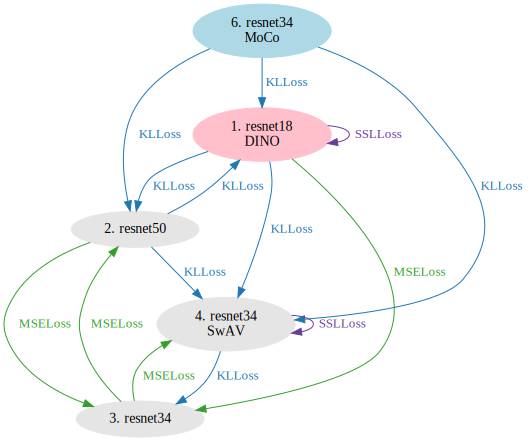

In [5]:
def get_node_name(top_series, model_id, models, ssls, gate_names_list):
    gate_name = top_series[f"params_{model_id}_{model_id}_gate"]
    if gate_name == "CutoffGate" and not all(gate_name == "CutoffGate" for gate_name in gate_names_list[model_id]):
        return f"{model_id+1}. {top_series[models[model_id]]}"
    else:
        return f"{model_id+1}. {top_series[models[model_id]]}\n{top_series[ssls[model_id]]}"

def get_edge_color(loss_name):
    return {"SSLLoss": "10", "MSELoss": "4", "KLLoss": "2"}[loss_name]

def create_graph(sorted_df, top):
    top_series = sorted_df.iloc[top]
    models = sorted(list(filter(lambda x: "model" in x, top_series.keys())))
    ssls = sorted(list(filter(lambda x: "ssl" in x, top_series.keys())))
    
    del_node = []
    while True:
        gate_names_list = [
            [
                top_series[f"params_{j}_{model_id}_gate"] 
                for j, _ in enumerate(models) if model_id != j and j not in del_node
            ] 
            for model_id, _ in enumerate(models)
        ]
        new_del_node = [model_id for model_id, gate_names in enumerate(gate_names_list) if all(gate_name == "CutoffGate" for gate_name in gate_names)]
        if len(del_node) == len(new_del_node):
            break
        del_node = new_del_node

    gate_names_list = [
        [
            top_series[f"params_{model_id}_{j}_gate"] 
            for j, _ in enumerate(models)
        ]
        for model_id, _ in enumerate(models)
    ]
                
    G = Digraph(format="svg")
    for model_id, _ in enumerate(models):
        if model_id in del_node:
            continue
        color = "pink" if model_id == 0 else "gray90"
        node_name = get_node_name(top_series, model_id, models, ssls, gate_names_list)
        G.node(node_name, color=color, fillcolor=color, style="filled")

        for j, _ in enumerate(models):
            gate_name = top_series[f"params_{model_id}_{j}_gate"]
            loss_name = top_series[f"params_{model_id}_{j}_loss"]
            if gate_name == "CutoffGate":
                continue
            n = get_node_name(top_series, j, models, ssls, gate_names_list)
            edge_color = get_edge_color(loss_name)
            G.edge(n, node_name, label=loss_name, fontsize="13", fontcolor=edge_color, color=edge_color, colorscheme="paired12")

        if all(gate_name == "CutoffGate" for gate_name in gate_names_list[model_id]):
            G.node(node_name, color="lightblue", fillcolor="lightblue", style="filled")
    return G

G = create_graph(sorted_df, 2)
display(G)
